Same as original microgrid code.  Changed running cost. Changed I0 as I0 = (Imin+Imax)/2 

In [86]:
import numpy as np

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from scipy.stats import qmc

# Batch design parameters
sites = 512; batch = 20; nsim = sites * batch

# parameters

#storage 
global C; C = np.array([5,10**5]);
global switchCost; switchCost = 10;
global no_regime; no_regime = 2
global degree; degree = 3
maturity = 24 * 2 # units are in hours
global dt; dt = 15/60;
nstep = int(maturity/dt)

In [87]:
def demandSimulate(α, K0, σ, n_step, n_sim, maturity, P0):
    
    dt = maturity/n_step
    priceMatrix = np.zeros((n_sim, n_step+1))
    priceMatrix[:,0] = np.ones(n_sim) * P0
    
    dW = np.random.normal(0,1,size = (n_sim,n_step) ) * np.sqrt(dt)
    
    for i in range(1,n_step+1):
        priceMatrix[:,i] = priceMatrix[:,i-1] + α * (K0 - priceMatrix[:,i-1]) * dt + σ * dW[:,i-1]
        
    return priceMatrix

Running cost is operation of diesel cost+ quadratic of imbalance at eachs tep 


In [3]:
def oneStepOptimization_microgrid(Bminmax,Iminmax,demand,ICord,coeff):
    
    # regime 0= injection, 1 = withdrawal, 2  = do nothing
    # Batch design parameters
    nsim = len(demand)
    
    B_max = Bminmax[1];
    B_min = Bminmax[0];

    I_max = Iminmax[1];
    I_min = Iminmax[0];
    
    
    #c_tk in 2D
    possibleControl = np.zeros((nsim,2));
    possibleControl[:,1] = demand*(demand>0) + np.minimum(B_max,(I_max - ICord)/dt)
    
    #notice that demand has one column, but possible control has 2 columns.
    # demandExControl as a result has 2 columns. 

    # ct- Xt for each possible control
    demand2D = np.column_stack((demand,demand))
    demandExControl = possibleControl - demand2D;
    
    ICord2D = np.column_stack((ICord,ICord))
    

    constraint1 = np.maximum(B_min, demandExControl)
    constraint2 = np.minimum(constraint1,B_max)
    constraint3 = np.minimum(constraint2, (I_max - ICord2D)/dt)
    #Bt in 2D
    Bt = np.maximum(-ICord2D/dt, constraint3)

    #St in 2D
    St = demandExControl - Bt
    # I_t+1 effectively
    It = ICord2D + Bt * dt;

    costON = (possibleControl[:,1]**0.9) * dt +St[:,1]**2 *dt;
    costOFF =  St[:,0]**2 * dt;
    #V_on
    espBellmanON = np.zeros((nsim,no_regime)); 
    #V_off
    espBellmanOFF=np.zeros((nsim,no_regime));
    #optimal m 
    nextRegime =  np.ones((nsim,no_regime)); 
    # optimal i
    nextInventory = np.zeros((nsim,no_regime));     
    stepCost = np.zeros((nsim,no_regime));    
    cost = np.zeros((nsim,no_regime));     
    imbalance = np.zeros((nsim,no_regime));     
    batteryOutput = np.zeros((nsim,no_regime));
    control = np.zeros((nsim,no_regime));   
    
    # r=0 off and r=1 on, in each one, find optimal contrl next step 
    for r in range(no_regime):
        
        X = np.column_stack((demand, It[:,0]))
        poly = preprocessing.PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)

        pred0 = coeff[0].predict(X_poly)
        espBellmanOFF[:,r] = costOFF +pred0;
        
        X = np.column_stack((demand, It[:,1]))
        poly = preprocessing.PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)

        pred1 = coeff[1].predict(X_poly)
        
        #Vt+1 following mt = r to mt+1 = 1, plus switch cost if r = 0 .
        espBellmanON[:,r] =  costON + pred1 + switchCost*(r==0) ;
        
        #???
        #check = possibleControl[:,1]<0.000001;
        #espBellmanON[check,r]=10**11;
        
        #get indx where Vt+1(off)< Vt+1(on)
        #minimization 
        indx = espBellmanOFF[:,r] < espBellmanON[:,r];
        # optimal mt+1
        nextRegime[:,r] = 0 *indx + 1 *(1-indx);
        #gives pi not pi delta
        stepCost[:,r] =  costOFF * indx + costON * (1-indx);
        # get Vt_1 optimal
        cost[:,r] = espBellmanOFF[:,r] * indx + espBellmanON[:,r] * (1-indx);
        # optimal It+1
        nextInventory[:,r]= It[:,0] * indx + It[:,1] * (1-indx);
        # optimal imbalance following control
        imbalance[:,r]= St[:,0] * indx + St[:,1] * (1-indx);
        #optimal control at t+1starting at r at t
        control[:,r] = possibleControl[:,0] * indx + possibleControl[:,1] * (1-indx);
        batteryOutput[:,r] = Bt[:,0] * indx + Bt[:,1] * (1-indx); 
        
    return [cost, stepCost, control, nextInventory, nextRegime, imbalance, batteryOutput]

I_T starts from [0,Imax]. Final cost is same.

In [9]:
def microgrid_poly2d(B_range,I_range):

    # stock
    alpha = 0.5; K0 = 0; sigma = 2; processType = "Regular";

    # backward simulation
    
    sampler = qmc.Sobol(d=2, scramble=False)
    # 512 samples
    W = sampler.random_base2(m=9)
    X0 = -10 + 20*W[:,0]; # Residual demand (ou process)in [-10,10]
    ICord = I_range[1]*W[:,1];    # It in[0,Imax = 10]
    ICord_rep = np.repeat(ICord,batch);
    X0_rep = np.repeat(X0,batch);

    demandMatrix = demandSimulate(alpha, K0, sigma, 1, nsim, dt, X0_rep);
    # I0 is middle of I_range
    I0 = np.mean(I_range)
    finalCost = 200 * np.maximum(I0-ICord_rep,0)
    # 20 rows, 512 columns,create 20x512 matrix, filled by column wise with order = "F" (default fill row), 
    # take row sum mean  to get final cost for each starting site
    finalCost = np.mean(finalCost.reshape((batch,sites),order = "F"),axis = 0)

    costNext = np.zeros((sites,no_regime));

    for r in range(no_regime):
        costNext[:,r] = finalCost;

    modelIndx = 0; global Model ; Model = [None] * (nstep)
    polyMdl = [None]*no_regime
    for iStep in range(nstep,0,-1):
        for r in range(no_regime):
            polyMdl[r] = LinearRegression()

            X_train = np.column_stack((X0, ICord))

            poly = preprocessing.PolynomialFeatures(degree=3)
            X_poly = poly.fit_transform(X_train)

            y_train = costNext[:, r]
            polyMdl[r].fit(X_poly, y_train)
        
        # generate X_t 
        demandMatrix = demandSimulate(alpha, K0, sigma, 1, nsim, dt, X0_rep);

        # optimize basedd on X_t-1,I_t
        cost, _, control, nextInventory, nextRegime, imbalance, batteryOutput =\
        oneStepOptimization_microgrid(B_range,I_range,demandMatrix[:, 1], ICord_rep, polyMdl)

        for r in range(no_regime):
            costNext[:, r] = np.mean(cost[:, r].reshape((batch, sites),order = "F"), axis=0)
    
        Model[modelIndx] = polyMdl.copy();
        modelIndx+=1;    


    # forward simulations 
    np.random.seed(10)
    simOutSample = 200000;

    X0 = np.zeros(simOutSample);
    I0 = I0;
    demandMatrix = demandSimulate(alpha, K0, sigma, nstep, simOutSample, maturity, X0);

    inventoryForward = np.zeros((simOutSample,nstep+1));
    inventoryForward[:, 0] = I0

    regimeForward = np.zeros((simOutSample, nstep + 1))
    regimeForward[:, 0] = 0
    
    Bt = np.zeros((simOutSample, nstep))
    St = np.zeros((simOutSample, nstep))
    dieselPower = np.zeros((simOutSample, nstep))
    trueCost = np.zeros((simOutSample, nstep))
    artificialCost = np.zeros((simOutSample, nstep))
    
    costForward = np.zeros((simOutSample, nstep + 1))
    
    for iStep in range(nstep):
        _, _, control, nextInventory, nextRegime, imbalance, batteryOutput = \
        oneStepOptimization_microgrid(B_range,I_range,demandMatrix[:, iStep], inventoryForward[:, iStep], Model[nstep - iStep-1])
        row_idx = tuple(np.arange(0,simOutSample))
        col_idx = tuple(np.int64(regimeForward[:,iStep]))
        #if iStep%20 ==0:
            #print(col_idx[:10],iStep,nstep)
        inventoryForward[:, iStep + 1] = nextInventory[row_idx,col_idx]
        regimeForward[:, iStep + 1] = nextRegime[row_idx,col_idx]
        Bt[:, iStep] = batteryOutput[row_idx,col_idx]
        St[:, iStep] = imbalance[row_idx,col_idx]
        dieselPower[:, iStep] = control[row_idx,col_idx]
        #diesel cost
        trueCost[:, iStep] = (dieselPower[:, iStep] ** 0.9) * dt + switchCost * (regimeForward[:, iStep + 1] \
                                                                                 > regimeForward[:, iStep])
        #non diesel cost
        artificialCost[:, iStep] = np.abs(St[:, iStep])**2 * dt 
    
    penalty = 200 * np.maximum(I0-inventoryForward[:, -1] ,0)
    costForward = trueCost + artificialCost
    pathWiseCost = np.sum(costForward, axis=1) + penalty
    totalCost = np.mean(pathWiseCost)
    stdDeviation = np.std(pathWiseCost) / np.sqrt(simOutSample)
    totalTrueCost = np.mean(np.sum(trueCost, axis=1))
    totalArtificialCost = np.mean(np.sum(artificialCost, axis=1))
    
    print(f'nsim: {sites} x {batch}, regime=1, totalCost= {totalCost}, totalTrueCost= {totalTrueCost}, totalArtificialCost= {totalArtificialCost}')


    return totalCost,totalTrueCost,totalArtificialCost

Here, I0 is middle of $[0,I_{max}]$(changing). Drift is 0.5. vol is 2(fixed) in each experiment So, when I_0 is large, it may never discharge completely as drift and volatility may be not significant compared to I_t.

In [10]:
B_max = np.arange(5,100+5,5)
I_max  = np.arange(5,100+1,5)
total_cost = np.zeros((len(I_max),len(B_max)))
total_TrueCost = np.zeros((len(I_max),len(B_max)))
total_ArtificialCost = np.zeros((len(I_max),len(B_max)))
for i in range(len(B_max)):
    for j in range(len(I_max)):
        Bminmax = np.array([-B_max[i],B_max[i]])
        Iminmax = np.array([0,I_max[j]])
        total_cost[j,i],total_TrueCost[j,i],total_ArtificialCost[j,i] = microgrid_poly2d(Bminmax,Iminmax)
        print(Bminmax,Iminmax)

nsim: 512 x 20, regime=1, totalCost= 126.30162485880754, totalTrueCost= 26.691377888162158, totalArtificialCost= 99.61024697064539
[-5  5] [0 5]
nsim: 512 x 20, regime=1, totalCost= 104.77527558453532, totalTrueCost= 20.916476800824192, totalArtificialCost= 83.85879878371112
[-5  5] [ 0 10]
nsim: 512 x 20, regime=1, totalCost= 87.9848412518719, totalTrueCost= 20.444104722563573, totalArtificialCost= 67.54073652930833
[-5  5] [ 0 15]
nsim: 512 x 20, regime=1, totalCost= 77.51353658673227, totalTrueCost= 22.639591346219465, totalArtificialCost= 54.873945240512796
[-5  5] [ 0 20]
nsim: 512 x 20, regime=1, totalCost= 69.89864979676933, totalTrueCost= 25.077540967375906, totalArtificialCost= 44.82110882939343
[-5  5] [ 0 25]
nsim: 512 x 20, regime=1, totalCost= 63.980294181366254, totalTrueCost= 27.460447265653535, totalArtificialCost= 36.51984691571273
[-5  5] [ 0 30]
nsim: 512 x 20, regime=1, totalCost= 59.148187587128376, totalTrueCost= 29.7204803513091, totalArtificialCost= 29.427707235

nsim: 512 x 20, regime=1, totalCost= 54.645186391198465, totalTrueCost= 49.930462003803484, totalArtificialCost= 4.714724387394951
[-15  15] [ 0 85]
nsim: 512 x 20, regime=1, totalCost= 55.72282873334121, totalTrueCost= 51.582294290848004, totalArtificialCost= 4.140534442493198
[-15  15] [ 0 90]
nsim: 512 x 20, regime=1, totalCost= 56.959710559839316, totalTrueCost= 53.24269863237888, totalArtificialCost= 3.7170119274604327
[-15  15] [ 0 95]
nsim: 512 x 20, regime=1, totalCost= 58.309858289981655, totalTrueCost= 54.902125132668644, totalArtificialCost= 3.407733157313018
[-15  15] [  0 100]
nsim: 512 x 20, regime=1, totalCost= 127.8279603221181, totalTrueCost= 17.87194127433003, totalArtificialCost= 109.95600776984014
[-20  20] [0 5]
nsim: 512 x 20, regime=1, totalCost= 101.38369622463283, totalTrueCost= 18.853862988644718, totalArtificialCost= 82.52983323598812
[-20  20] [ 0 10]
nsim: 512 x 20, regime=1, totalCost= 85.3203190868317, totalTrueCost= 15.916050961206919, totalArtificialCos

nsim: 512 x 20, regime=1, totalCost= 44.27301698704871, totalTrueCost= 34.657422142842826, totalArtificialCost= 9.615594844205898
[-30  30] [ 0 65]
nsim: 512 x 20, regime=1, totalCost= 44.12059447214799, totalTrueCost= 36.35842759223807, totalArtificialCost= 7.762166879909908
[-30  30] [ 0 70]
nsim: 512 x 20, regime=1, totalCost= 44.28212071239956, totalTrueCost= 37.96706744958916, totalArtificialCost= 6.3150532628104115
[-30  30] [ 0 75]
nsim: 512 x 20, regime=1, totalCost= 44.73524411125093, totalTrueCost= 39.53568166719246, totalArtificialCost= 5.199562444058464
[-30  30] [ 0 80]
nsim: 512 x 20, regime=1, totalCost= 45.467456448082906, totalTrueCost= 41.12839581358333, totalArtificialCost= 4.339060634499584
[-30  30] [ 0 85]
nsim: 512 x 20, regime=1, totalCost= 46.416538709250595, totalTrueCost= 42.73450325641528, totalArtificialCost= 3.682035452835319
[-30  30] [ 0 90]
nsim: 512 x 20, regime=1, totalCost= 47.49925784254978, totalTrueCost= 44.305221256522714, totalArtificialCost= 3.

nsim: 512 x 20, regime=1, totalCost= 44.591617296123665, totalTrueCost= 21.521556929417564, totalArtificialCost= 23.070060366706095
[-45  45] [ 0 45]
nsim: 512 x 20, regime=1, totalCost= 42.203282897917454, totalTrueCost= 23.47306157519275, totalArtificialCost= 18.730221322724688
[-45  45] [ 0 50]
nsim: 512 x 20, regime=1, totalCost= 40.45912087934462, totalTrueCost= 25.410932692895628, totalArtificialCost= 15.048188186448991
[-45  45] [ 0 55]
nsim: 512 x 20, regime=1, totalCost= 39.27711938791603, totalTrueCost= 27.23425268362415, totalArtificialCost= 12.04286670429188
[-45  45] [ 0 60]
nsim: 512 x 20, regime=1, totalCost= 38.536077313860986, totalTrueCost= 28.922038516021438, totalArtificialCost= 9.614038797839557
[-45  45] [ 0 65]
nsim: 512 x 20, regime=1, totalCost= 38.17284656332135, totalTrueCost= 30.488168701096516, totalArtificialCost= 7.684677862224829
[-45  45] [ 0 70]
nsim: 512 x 20, regime=1, totalCost= 38.154094042804495, totalTrueCost= 31.975653238694967, totalArtificialC

nsim: 512 x 20, regime=1, totalCost= 62.76175013746313, totalTrueCost= 11.491545823850846, totalArtificialCost= 51.27020431361226
[-60  60] [ 0 25]
nsim: 512 x 20, regime=1, totalCost= 55.25854151661836, totalTrueCost= 17.802240042502802, totalArtificialCost= 37.45630147411554
[-60  60] [ 0 30]
nsim: 512 x 20, regime=1, totalCost= 49.52494766818011, totalTrueCost= 15.789804133984063, totalArtificialCost= 33.73514353419608
[-60  60] [ 0 35]
nsim: 512 x 20, regime=1, totalCost= 44.14493740177184, totalTrueCost= 15.473707962226987, totalArtificialCost= 28.671229439544888
[-60  60] [ 0 40]
nsim: 512 x 20, regime=1, totalCost= 41.56631487106663, totalTrueCost= 18.446042364633886, totalArtificialCost= 23.120272506432748
[-60  60] [ 0 45]
nsim: 512 x 20, regime=1, totalCost= 39.003030235056784, totalTrueCost= 20.199512430939887, totalArtificialCost= 18.803517804116893
[-60  60] [ 0 50]
nsim: 512 x 20, regime=1, totalCost= 37.212636454404944, totalTrueCost= 22.06644807790929, totalArtificialCo

nsim: 512 x 20, regime=1, totalCost= 127.8279603221181, totalTrueCost= 17.87194127433003, totalArtificialCost= 109.95600776984014
[-75  75] [0 5]
nsim: 512 x 20, regime=1, totalCost= 99.0038871695243, totalTrueCost= 15.123402185943538, totalArtificialCost= 83.88048498358076
[-75  75] [ 0 10]
nsim: 512 x 20, regime=1, totalCost= 81.81796582772388, totalTrueCost= 13.210162143119051, totalArtificialCost= 68.60780368460483
[-75  75] [ 0 15]
nsim: 512 x 20, regime=1, totalCost= 69.51445984826218, totalTrueCost= 12.857570329117255, totalArtificialCost= 56.65688951914492
[-75  75] [ 0 20]
nsim: 512 x 20, regime=1, totalCost= 71.01878784394856, totalTrueCost= 16.53077326556748, totalArtificialCost= 54.4880145783811
[-75  75] [ 0 25]
nsim: 512 x 20, regime=1, totalCost= 56.07799106168565, totalTrueCost= 11.942295838651638, totalArtificialCost= 44.13569522303401
[-75  75] [ 0 30]
nsim: 512 x 20, regime=1, totalCost= 47.801117223246564, totalTrueCost= 18.15796547365937, totalArtificialCost= 29.64

nsim: 512 x 20, regime=1, totalCost= 30.43393646949356, totalTrueCost= 26.536651535491966, totalArtificialCost= 3.8972849340015894
[-85  85] [ 0 85]
nsim: 512 x 20, regime=1, totalCost= 30.79632815674005, totalTrueCost= 27.667450600584782, totalArtificialCost= 3.128877556155274
[-85  85] [ 0 90]
nsim: 512 x 20, regime=1, totalCost= 31.295952538433145, totalTrueCost= 28.756260449646003, totalArtificialCost= 2.539692088787131
[-85  85] [ 0 95]
nsim: 512 x 20, regime=1, totalCost= 31.95223760600956, totalTrueCost= 29.863129352173104, totalArtificialCost= 2.0891082538364567
[-85  85] [  0 100]
nsim: 512 x 20, regime=1, totalCost= 127.8279603221181, totalTrueCost= 17.87194127433003, totalArtificialCost= 109.95600776984014
[-90  90] [0 5]
nsim: 512 x 20, regime=1, totalCost= 99.0038871695243, totalTrueCost= 15.123402185943538, totalArtificialCost= 83.88048498358076
[-90  90] [ 0 10]
nsim: 512 x 20, regime=1, totalCost= 81.81796582772388, totalTrueCost= 13.210162143119051, totalArtificialCost

nsim: 512 x 20, regime=1, totalCost= 30.412175854964936, totalTrueCost= 18.875556637117924, totalArtificialCost= 11.536619217847013
[-100  100] [ 0 65]
nsim: 512 x 20, regime=1, totalCost= 28.7202446392742, totalTrueCost= 20.860279815589756, totalArtificialCost= 7.859964823684445
[-100  100] [ 0 70]
nsim: 512 x 20, regime=1, totalCost= 28.488364223355305, totalTrueCost= 22.32268774194756, totalArtificialCost= 6.165676481407744
[-100  100] [ 0 75]
nsim: 512 x 20, regime=1, totalCost= 28.3389193107641, totalTrueCost= 23.455774195890235, totalArtificialCost= 4.8831451148738605
[-100  100] [ 0 80]
nsim: 512 x 20, regime=1, totalCost= 28.569082062799566, totalTrueCost= 24.69570555694163, totalArtificialCost= 3.8733765058579466
[-100  100] [ 0 85]
nsim: 512 x 20, regime=1, totalCost= 28.96165805041596, totalTrueCost= 25.871439960331152, totalArtificialCost= 3.0902180900848086
[-100  100] [ 0 90]
nsim: 512 x 20, regime=1, totalCost= 29.49395320277082, totalTrueCost= 27.00591288091056, totalAr

In [20]:
np.save("total_cost",total_cost)
np.save("total_TrueCost",total_TrueCost)
np.save("total_ArtificialCost",total_ArtificialCost)

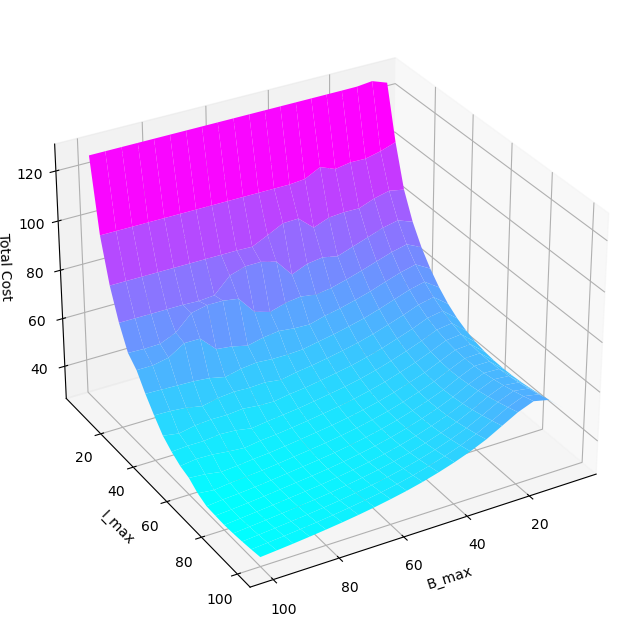

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
X, Y = np.meshgrid(B_max, I_max)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_cost, cmap='cool', alpha=1)
ax.view_init(30, 60)
ax.set_xlabel('B_max')
ax.set_ylabel('I_max')
ax.set_zlabel('Total Cost')
plt.show()

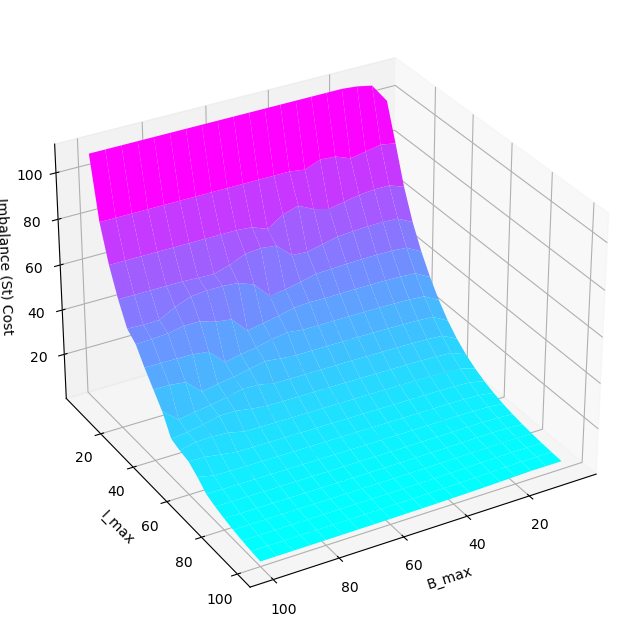

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
X, Y = np.meshgrid(B_max, I_max)

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, total_ArtificialCost, cmap='cool', alpha=1)
ax.view_init(30, 60)
ax.set_xlabel('B_max')
ax.set_ylabel('I_max')
ax.set_zlabel('Imbalance (St) Cost')
plt.show()

In [69]:
def microgrid_poly2d(B_range,I_range):

    # stock
    alpha = 0.5; K0 = 0; sigma = 2; processType = "Regular";

    # backward simulation
    
    sampler = qmc.Sobol(d=2, scramble=False)
    # 512 samples
    W = sampler.random_base2(m=9)
    X0 = -10 + 20*W[:,0]; # Residual demand (ou process)in [-10,10]
    ICord = I_range[1]*W[:,1];    # It in[0,Imax = 10]
    ICord_rep = np.repeat(ICord,batch);
    X0_rep = np.repeat(X0,batch);

    demandMatrix = demandSimulate(alpha, K0, sigma, 1, nsim, dt, X0_rep);
    # I0 is middle of I_range
    I0 = np.mean(I_range)
    finalCost = 200 * np.maximum(I0-ICord_rep,0)
    # 20 rows, 512 columns,create 20x512 matrix, filled by column wise with order = "F" (default fill row), 
    # take row sum mean  to get final cost for each starting site
    finalCost = np.mean(finalCost.reshape((batch,sites),order = "F"),axis = 0)

    costNext = np.zeros((sites,no_regime));

    for r in range(no_regime):
        costNext[:,r] = finalCost;

    modelIndx = 0; global Model ; Model = [None] * (nstep)
    polyMdl = [None]*no_regime
    for iStep in range(nstep,0,-1):
        for r in range(no_regime):
            polyMdl[r] = LinearRegression()

            X_train = np.column_stack((X0, ICord))

            poly = preprocessing.PolynomialFeatures(degree=3)
            X_poly = poly.fit_transform(X_train)

            y_train = costNext[:, r]
            polyMdl[r].fit(X_poly, y_train)
        
        # generate X_t 
        demandMatrix = demandSimulate(alpha, K0, sigma, 1, nsim, dt, X0_rep);

        # optimize basedd on X_t-1,I_t
        cost, _, control, nextInventory, nextRegime, imbalance, batteryOutput =\
        oneStepOptimization_microgrid(B_range,I_range,demandMatrix[:, 1], ICord_rep, polyMdl)

        for r in range(no_regime):
            costNext[:, r] = np.mean(cost[:, r].reshape((batch, sites),order = "F"), axis=0)
    
        Model[modelIndx] = polyMdl.copy();
        modelIndx+=1;    


    # forward simulations 
    np.random.seed(10)
    simOutSample = 200000;

    X0 = np.zeros(simOutSample);
    I0 = I0;
    demandMatrix = demandSimulate(alpha, K0, sigma, nstep, simOutSample, maturity, X0);

    inventoryForward = np.zeros((simOutSample,nstep+1));
    inventoryForward[:, 0] = I0

    regimeForward = np.zeros((simOutSample, nstep + 1))
    regimeForward[:, 0] = 0
    
    Bt = np.zeros((simOutSample, nstep))
    St = np.zeros((simOutSample, nstep))
    dieselPower = np.zeros((simOutSample, nstep))
    trueCost = np.zeros((simOutSample, nstep))
    artificialCost = np.zeros((simOutSample, nstep))
    
    costForward = np.zeros((simOutSample, nstep + 1))
    
    for iStep in range(nstep):
        _, _, control, nextInventory, nextRegime, imbalance, batteryOutput = \
        oneStepOptimization_microgrid(B_range,I_range,demandMatrix[:, iStep], inventoryForward[:, iStep], Model[nstep - iStep-1])
        row_idx = tuple(np.arange(0,simOutSample))
        col_idx = tuple(np.int64(regimeForward[:,iStep]))
        #if iStep%20 ==0:
            #print(col_idx[:10],iStep,nstep)
        inventoryForward[:, iStep + 1] = nextInventory[row_idx,col_idx]
        regimeForward[:, iStep + 1] = nextRegime[row_idx,col_idx]
        Bt[:, iStep] = batteryOutput[row_idx,col_idx]
        St[:, iStep] = imbalance[row_idx,col_idx]
        dieselPower[:, iStep] = control[row_idx,col_idx]
        #diesel cost
        trueCost[:, iStep] = (dieselPower[:, iStep] ** 0.9) * dt + switchCost * (regimeForward[:, iStep + 1] \
                                                                                 > regimeForward[:, iStep])
        #non diesel cost
        artificialCost[:, iStep] = np.abs(St[:, iStep])**2 * dt 
    
    penalty = 200 * np.maximum(I0-inventoryForward[:, -1] ,0)
    costForward = trueCost + artificialCost
    pathWiseCost = np.sum(costForward, axis=1) + penalty
    totalCost = np.mean(pathWiseCost)
    stdDeviation = np.std(pathWiseCost) / np.sqrt(simOutSample)
    totalTrueCost = np.mean(np.sum(trueCost, axis=1))
    totalArtificialCost = np.mean(np.sum(artificialCost, axis=1))
    
    print(f'nsim: {sites} x {batch}, regime=1, totalCost= {totalCost}, totalTrueCost= {totalTrueCost}, totalArtificialCost= {totalArtificialCost}')



    return [demandMatrix,inventoryForward,Bt,St,dieselPower,regimeForward]

nsim: 512 x 20, regime=1, totalCost= 103.92091827953101, totalTrueCost= 20.722426115350007, totalArtificialCost= 83.19849216418096


[]

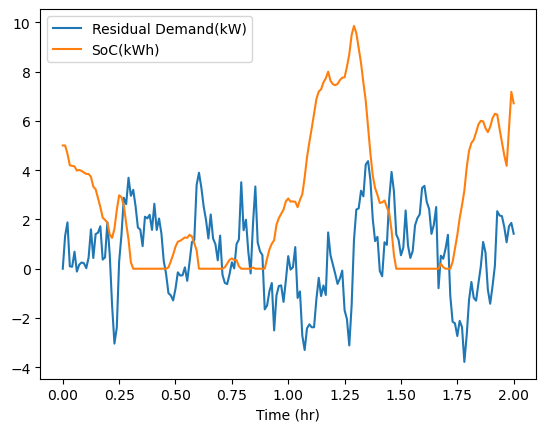

In [80]:
mdl = microgrid_poly2d(B_range = [-6,6], I_range = [0,10])

res_demand = mdl[0][0,:] #193
opt_It = mdl[1][0,:] 
opt_Bt  = mdl[2][0,:]
opt_imbalance = mdl[3][0,:]
import matplotlib.pyplot as plt
t = np.linspace(0,2,193)

plt.plot(t,res_demand)
plt.plot(t,opt_It)
#plt.plot(t,np.insert(opt_diesel,0,0))
plt.legend(["Residual Demand(kW)", "SoC(kWh)", "Diesel Power"])
# demand is negative, charge, demand is positive, discharge

plt.xlabel("Time (hr)")

plt.plot()

[]

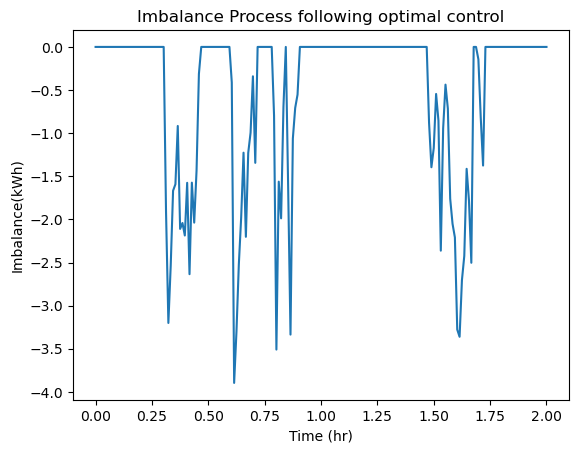

In [81]:
import matplotlib.pyplot as plt
t = np.linspace(0,2,193)


plt.plot(t,np.insert(opt_imbalance,0,0))

# demand is negative, charge, demand is positive, discharge
plt.ylabel("Imbalance(kWh)")
plt.xlabel("Time (hr)")
plt.title("Imbalance Process following optimal control")
plt.plot()

nsim: 512 x 20, regime=1, totalCost= 39.5409175473921, totalTrueCost= 37.157851591604214, totalArtificialCost= 2.3830659557878833


[]

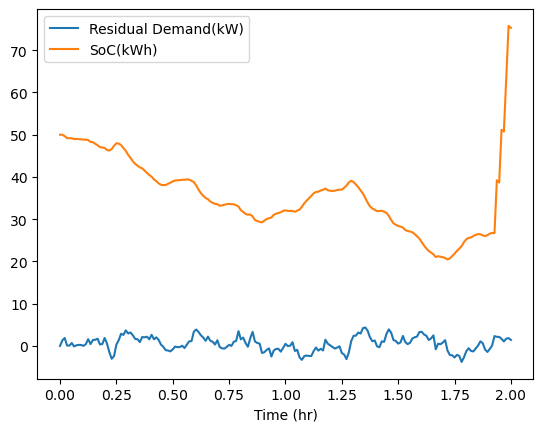

In [82]:
mdl = microgrid_poly2d(B_range = [-50,50], I_range = [0,100])

res_demand = mdl[0][0,:] #193
opt_It = mdl[1][0,:] 
opt_Bt  = mdl[2][0,:]
opt_imbalance = mdl[3][0,:]
import matplotlib.pyplot as plt
t = np.linspace(0,2,193)

plt.plot(t,res_demand)
plt.plot(t,opt_It)
#plt.plot(t,np.insert(opt_diesel,0,0))
plt.legend(["Residual Demand(kW)", "SoC(kWh)", "Diesel Power"])
# demand is negative, charge, demand is positive, discharge

plt.xlabel("Time (hr)")

plt.plot()

[]

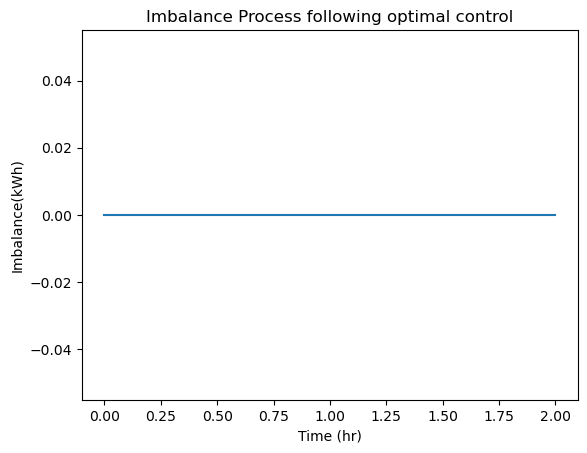

In [85]:
import matplotlib.pyplot as plt
t = np.linspace(0,2,193)


plt.plot(t,np.insert(opt_imbalance,0,0))

# demand is negative, charge, demand is positive, discharge
plt.ylabel("Imbalance(kWh)")
plt.xlabel("Time (hr)")
plt.title("Imbalance Process following optimal control")
plt.plot()

In [ ]:
Next, test on battery without help of generator. 0 = do nothing, 1 = charge to max, -1 = discharge to min